# Tensorflow probability for regression

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from scipy.stats import norm

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense

import tensorflow_probability as tfp
tfd = tfp.distributions

## Usecase: linear RUL with masksembles

**Define the data function and parameter limits**

In [5]:
# Define linear function
def func(x, a, c, noise_amp = 0):
    y = a*x + c
    y = y + noise_amp * np.random.randn(len(x))
    return y

In [6]:
np.random.seed(2049)

def create_dataset(x, n_training_obs=1000):

    x = np.arange(0,10,0.1)
    a_range = (0, 2)
    c_range = (0, 10)
    noise_range = (0,5)

    a_list = np.random.rand(n_training_obs)*(a_range[1] - a_range[0]) + a_range[0]
    c_list = np.random.rand(n_training_obs)*(c_range[1] - c_range[0]) + c_range[0]
    noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]

    targets = np.array(list(zip(a_list,c_list)))
    targets_with_noise = np.array(list(zip(a_list,c_list,noise_list)))
    features = np.array([func(x,a,c,noise) for a, c, noise in targets_with_noise])

    return features, targets, noise_list

x = np.arange(0,10,0.1)
features, targets, noise_list = create_dataset(x, 10000)

**Create a custom loss function**

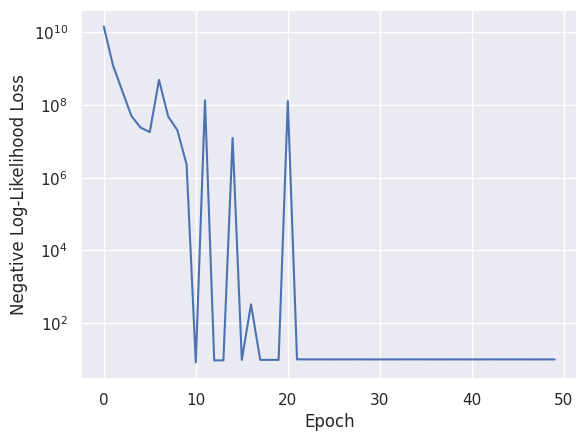

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from scipy.stats import norm

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense

import tensorflow_probability as tfp
tfd = tfp.distributions

# Define linear function
def func(x, a, c, noise_amp = 0):
    y = a*x + c
    y = y + noise_amp * np.random.randn(len(x))
    return y

np.random.seed(2049)

def create_dataset(x, n_training_obs=1000):

    x = np.arange(0,10,0.1)
    a_range = (0, 2)
    c_range = (0, 10)
    noise_range = (0,5)

    a_list = np.random.rand(n_training_obs)*(a_range[1] - a_range[0]) + a_range[0]
    c_list = np.random.rand(n_training_obs)*(c_range[1] - c_range[0]) + c_range[0]
    noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]

    targets = np.array(list(zip(a_list,c_list)))
    targets_with_noise = np.array(list(zip(a_list,c_list,noise_list)))
    features = np.array([func(x,a,c,noise) for a, c, noise in targets_with_noise])

    return features, targets, noise_list

x = np.arange(0,10,0.1)
features, targets, noise_list = create_dataset(x, 50000)

# Negative log-likelihood loss function
def negloglik(y, rv_y):
    return -rv_y.log_prob(y)

# Build model
input_shape = (100,)
kl_weight = 1.0 / features.shape[0]  # Adjust based on batch size for KL regularization

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype, initializer='zeros'),
        tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t, scale_diag=tf.ones_like(t)))
    ])
    return prior_model

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
            loc=t[..., :n],
            scale_diag=1e-5 + tf.nn.softplus(t[..., n:])
        ))
    ])
    return posterior_model

input_layer = tf.keras.layers.Input(shape=input_shape)
layer_x = tfp.layers.DenseVariational(
    units=50,
    make_posterior_fn=posterior_mean_field,
    make_prior_fn=prior_trainable,
    kl_weight=kl_weight,
    activation='relu'
)(input_layer)
layer_x = tfp.layers.DenseVariational(
    units=25,
    make_posterior_fn=posterior_mean_field,
    make_prior_fn=prior_trainable,
    kl_weight=kl_weight,
    activation='relu'
)(layer_x)
output_layer = tfp.layers.DenseVariational(
    units=2 + 2,  # Output both mean and log scale for each feature
    make_posterior_fn=posterior_mean_field,
    make_prior_fn=prior_trainable,
    kl_weight=kl_weight,
    activation=None
)(layer_x)

# Convert to a distribution with tfp.layers.DistributionLambda
output_distribution = tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=t[..., :2], scale=1e-3 + tf.nn.softplus(t[..., 2:]))
)(output_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_distribution)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=negloglik)


# Train model
history = model.fit(features, targets, epochs=50, batch_size=batch_size, verbose=0, shuffle=True)

# Plot the loss curve
plt.plot(history.history['loss'])
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood Loss')
plt.show()

In [48]:
features, targets, noise_list = create_dataset(x, 100)

In [49]:
predictions = model(features)

In [50]:
means = predictions.mean().numpy()      # Shape: (num_samples, 2)
stddevs = predictions.stddev().numpy()  # Shape: (num_samples, 2)

In [51]:
# Print the first 5 predictions
for i in range(5):
    print(f"Sample {i+1}:")
    print(f"  Predicted Means: {means[i]}")
    print(f"  Predicted Stddevs: {stddevs[i]}")
    print()


Sample 1:
  Predicted Means: [-1970.547   3322.7903]
  Predicted Stddevs: [ 9838.12  10982.375]

Sample 2:
  Predicted Means: [-1788.6415  3004.9475]
  Predicted Stddevs: [8828.84  9927.292]

Sample 3:
  Predicted Means: [-1240.1362  2024.2391]
  Predicted Stddevs: [6559.9185 7409.851 ]

Sample 4:
  Predicted Means: [-1550.5322  2829.2166]
  Predicted Stddevs: [7666.5596 8681.192 ]

Sample 5:
  Predicted Means: [-3025.0237  5360.951 ]
  Predicted Stddevs: [15721.14 17743.53]



In [52]:
targets[:5]

array([[1.10566587, 5.11861382],
       [0.45025086, 6.94730253],
       [0.50344033, 3.61082849],
       [1.40805066, 0.64933035],
       [1.83675112, 7.09510573]])

In [53]:
predictions.mean().numpy()[:5]

array([[-1970.547 ,  3322.7903],
       [-1788.6415,  3004.9475],
       [-1240.1362,  2024.2391],
       [-1550.5322,  2829.2166],
       [-3025.0237,  5360.951 ]], dtype=float32)

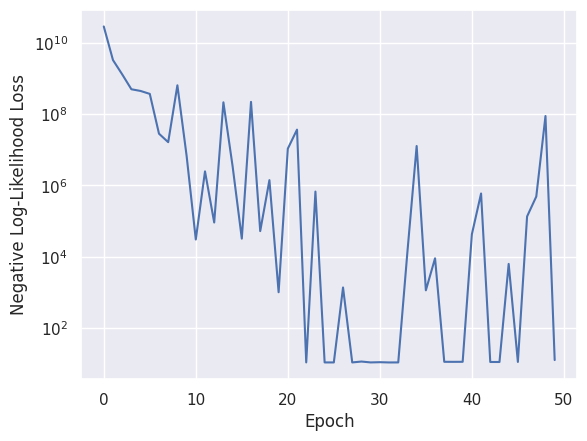

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from scipy.stats import norm

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense

import tensorflow_probability as tfp
tfd = tfp.distributions

# Define linear function
def func(x, a, c, noise_amp = 0):
    y = a*x + c
    y = y + noise_amp * np.random.randn(len(x))
    return y

np.random.seed(2049)

def create_dataset(x, n_training_obs=1000):

    x = np.arange(0,10,0.1)
    a_range = (0, 2)
    c_range = (0, 10)
    noise_range = (0,5)

    a_list = np.random.rand(n_training_obs)*(a_range[1] - a_range[0]) + a_range[0]
    c_list = np.random.rand(n_training_obs)*(c_range[1] - c_range[0]) + c_range[0]
    noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]

    targets = np.array(list(zip(a_list,c_list)))
    targets_with_noise = np.array(list(zip(a_list,c_list,noise_list)))
    features = np.array([func(x,a,c,noise) for a, c, noise in targets_with_noise])

    return features, targets, noise_list

x = np.arange(0,10,0.1)
features, targets, noise_list = create_dataset(x, 50000)

# Negative log-likelihood loss function
def negloglik(y, rv_y):
    return -rv_y.log_prob(y)

def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)


# Build model
input_shape = (100,)
kl_weight = 1.0 / features.shape[0]  # Adjust based on batch size for KL regularization

batch_size = 128  # Use your actual batch size
kl_weight = 1.0 / (features.shape[0] / batch_size)

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype, initializer='zeros'),
        tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t, scale_diag=tf.ones_like(t)))
    ])
    return prior_model

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
            loc=t[..., :n],
            scale_diag=1e-5 + tf.nn.softplus(t[..., n:])
        ))
    ])
    return posterior_model

input_layer = tf.keras.layers.Input(shape=input_shape)
layer_x = tfp.layers.DenseVariational(
    units=50,
    make_posterior_fn=posterior_mean_field,
    make_prior_fn=prior_trainable,
    kl_weight=kl_weight,
    activation='relu'
)(input_layer)
layer_x = tfp.layers.DenseVariational(
    units=25,
    make_posterior_fn=posterior_mean_field,
    make_prior_fn=prior_trainable,
    kl_weight=kl_weight,
    activation='relu'
)(layer_x)
output_layer = tfp.layers.DenseVariational(
    units=2 + 2,  # Output both mean and log scale for each feature
    make_posterior_fn=posterior_mean_field,
    make_prior_fn=prior_trainable,
    kl_weight=kl_weight,
    activation=None
)(layer_x)

# Convert to a distribution with tfp.layers.DistributionLambda
output_distribution = tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=t[..., :2], scale=1e-3 + tf.nn.softplus(t[..., 2:]))
)(output_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_distribution)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=negloglik)


# Train model
history = model.fit(features, targets, epochs=50, batch_size=batch_size, verbose=0, shuffle=True)

# Plot the loss curve
plt.plot(history.history['loss'])
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood Loss')
plt.show()

In [55]:
features, targets, noise_list = create_dataset(x, 100)
predictions = model(features)
means = predictions.mean().numpy()      # Shape: (num_samples, 2)
stddevs = predictions.stddev().numpy()  # Shape: (num_samples, 2)

targets[:5]

array([[1.10566587, 5.11861382],
       [0.45025086, 6.94730253],
       [0.50344033, 3.61082849],
       [1.40805066, 0.64933035],
       [1.83675112, 7.09510573]])

In [56]:
means[:5]

array([[-1284.6764 , -2015.2711 ],
       [-1200.7601 , -1893.8081 ],
       [ -703.50854, -1069.3872 ],
       [-1040.17   , -1532.6917 ],
       [-2013.7799 , -3122.562  ]], dtype=float32)

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from scipy.stats import norm

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense

import tensorflow_probability as tfp
tfd = tfp.distributions

# Define linear function
def func(x, a, c, noise_amp = 0):
    y = a*x + c
    y = y + noise_amp * np.random.randn(len(x))
    return y

np.random.seed(2049)

def create_dataset(x, n_training_obs=1000):

    x = np.arange(0,10,0.1)
    a_range = (0, 2)
    c_range = (0, 10)
    noise_range = (0,5)

    a_list = np.random.rand(n_training_obs)*(a_range[1] - a_range[0]) + a_range[0]
    c_list = np.random.rand(n_training_obs)*(c_range[1] - c_range[0]) + c_range[0]
    noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]

    targets = np.array(list(zip(a_list,c_list)))
    targets_with_noise = np.array(list(zip(a_list,c_list,noise_list)))
    features = np.array([func(x,a,c,noise) for a, c, noise in targets_with_noise])

    return features, targets, noise_list

x = np.arange(0,10,0.1)
features, targets, noise_list = create_dataset(x, 50000)

# Negative log-likelihood loss function
def negloglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

def prior_fn(dtype, shape, name, trainable, add_variable_fn):
    del name, trainable  # Unused
    return tfd.MultivariateNormalDiag(
        loc=tf.zeros(shape, dtype=dtype),
        scale_diag=tf.ones(shape, dtype=dtype)
    )



def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    def posterior_fn(inputs):
        del inputs  # inputs are not used directly here
        posterior_loc = tf.Variable(
            initial_value=tf.random.normal([n], stddev=0.1, dtype=dtype),
            name='posterior_loc',
            trainable=True
        )
        posterior_scale = tf.Variable(
            initial_value=tf.random.normal([n], mean=-3.0, stddev=0.1, dtype=dtype),
            name='posterior_scale',
            trainable=True
        )
        return tfd.MultivariateNormalDiag(
            loc=posterior_loc,
            scale_diag=1e-5 + tf.nn.softplus(posterior_scale)
        )
    return posterior_fn


# Build model
batch_size = 128  # Your actual batch size
num_batches = features.shape[0] / batch_size
kl_weight = 1.0 / num_batches

input_layer = tf.keras.layers.Input(shape=input_shape)
layer_x = tfp.layers.DenseVariational(
    units=50,
    make_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    make_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kl_weight=kl_weight,
    activation='relu'
)(input_layer)

layer_x = tfp.layers.DenseVariational(
    units=25,
    make_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    make_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kl_weight=kl_weight,
    activation='relu'
)(layer_x)

output_layer = tfp.layers.DenseVariational(
    units=2 + 2,
    make_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    make_prior_fn=tfp.layers.default_multivariate_normal_fn,
    kl_weight=kl_weight,
    activation=None
)(layer_x)

# Convert to a distribution with tfp.layers.DistributionLambda
output_distribution = tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=t[..., :2], scale=1e-3 + tf.nn.softplus(t[..., 2:]))
)(output_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_distribution)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=negloglik)


# Train model
history = model.fit(features, targets, epochs=50, batch_size=batch_size, verbose=0, shuffle=True)

# Plot the loss curve
plt.plot(history.history['loss'])
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood Loss')
plt.show()

TypeError: _fn() missing 2 required positional arguments: 'trainable' and 'add_variable_fn'